# Challenge Posos
-------------------------



<b>Contexte :</b>

Plus de 6 000 médicaments différents sont commercialisés en France. Non seulement les patients, mais aussi les professionnels de la santé restent incapables de les utiliser correctement lorsqu'ils n'ont pas un accès immédiat à l'information appropriée qu'ils  recherchent. Les médicaments restent responsables de plus de 144 000 hospitalisations chaque année en France, tandis qu'aux Etats-Unis, 1,5 million de personnes sont confrontées chaque année à un abus de médicaments. Les questions concernant la prescription, la dispensation ou l'utilisation des médicaments ne doivent jamais rester sans réponse. Ce qui est particulièrement intéressant à comprendre au sujet des demandes de renseignements sur les médicaments, c'est ce que les gens s'attendent à obtenir comme réponse : par exemple, les effets secondaires associés, les ingrédients ou les contre-indications. Des millions de questions sont posées chaque année sur les drogues. Il y a un nombre limité de types de requêtes, mais la même question peut être posée de plusieurs façons. Par conséquent, il est très difficile de comprendre l'information que les gens s'attendent à obtenir lorsqu'ils posent une question.

<b>Objectifs :</b>

Prédire pour chaque question l'intention associée.

<br>
<br>


<u><b><font size=4>Etapes du projet :</font></b></u><br>
<br>
1 - Nous avons entamé cette étude par une <font color=blue><b>exploration des données</b></font>, plus particulièrement sur le champs lexical employé dans les questions.<br><br>
2 - Phase de <font color=blue><b>documentation sur les types de réseaux de neuronnes</b></font> adaptés à de la classification multilabel de textes. les réseaux de neuronnes à convolutions et les réseaux de neuronnes récursifs à mémoire courte.<br><br>
3 - En parallèle nous nous sommes initiés à quelques méthodes de <font color=blue><b>Natural Language Processing</b></font>.
En particulier nous avons observé les résultats obtenus à partir de textes encodés en vecteurs denses via word embedding (word2vec) ou en vecteurs sparses codant les caractères.<br><br>
4 - Lors de l'encodage par caractère, un <font color=blue><b>poids spécifique a été affecté aux noms des médicaments</b></font> dans les questions.<br><br>
5 - Les hyper-paramètres ont été définis par <font color=blue><b>validation croisée</b></font>.<br><br>
6 - Les résultats ont été analysés par le biais d'une <font color=blue><b>matrice de confusion</b></font>.<br><br>
7 - Enfin, et du fait du déséquilibre très important des classes target, nous nous sommes essayés à l'<font color=blue><b>augmentation de données</b></font> puis nous avons analysé son impact sur la performance de notre modèle.<br><br><br>

In [1]:
import pandas as pd
%matplotlib inline
from sklearn.model_selection import train_test_split

# Read POSOS files
raw_df = pd.read_csv("input_train.csv")
target = pd.read_csv("output_train.csv")

In [2]:
raw_df.describe()

,ID
count,8028.000000
mean,4013.500000
std,2317.628314
min,0.000000
25%,2006.750000
50%,4013.500000
75%,6020.250000
max,8027.000000


In [3]:
# Exemple de questions posées 
pd.set_option('display.max_colwidth', -1)
raw_df.head(10)

,ID,question
0,0,"bonjour, je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous"
1,1,est ce que le motilium me soulagera contre les nausées?
2,2,"mon médecin m'a prescrit adenyl. au 2ème cachet des maux de tête terribles et au 3ème palpitations, sueurs froides, chaleur intense dans la tête, tremblements, fourmillements dans la lèvre supérieure, difficultés à respirer.. dès l'arrêt du médicament tous les symptômes ont disparu. cela est-il déjà arrivé à quelqu'un??"
3,3,Est-ce qu'il existe une forme adaptée aux enfant de 5ans du Micropakine ?
4,4,mon medecin me soigne pour une rhino pharingite et m'a prescrit du amoxicilline comme anti biotique. Est-ce vraiment pour cette indication?
5,5,je viens d'apprendre que je suis enceinte..savez-vous si je peux poursuivre le rubozinc ?
6,6,atrax n'est-il pas dangereux au long terme ?
7,7,je suis sous mercilon. J'ai des nausées et des saignements ?
8,8,"L'atenolol, c'est quoi ?"
9,9,"je prend trinordiol et à la fin de ma première plaquette j'ai eu ma première fois ac mn copain. la pilule est donc bien efficace dès le debut ? j'ai des douleur dans la poitrine, j'ai l'impression qu'ils ont un peu grossi ossi de plus, j'ai mal o bas du ventr,e dois je minkiété ou c simplemen, la periode dadaptation ??"


# Exploration des données

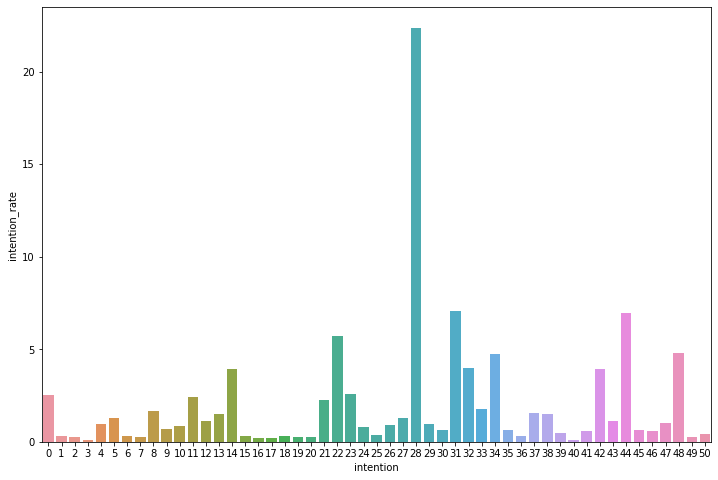

In [4]:
# Quelle est la répartition des classes target ?
import seaborn as sns
from matplotlib import pyplot as plt

def lmgp_print_intentiorate(target):
    a4_dims = (12, 8)
    
    # Distribution par ratio des intentions
    intention_rate = target["intention"].value_counts(normalize=True).mul(100).round(2).sort_index(ascending=True)

    intention_rate_df = pd.DataFrame({"intention":intention_rate.index, "intention_rate":intention_rate.values})
    fig, ax = plt.subplots(figsize=a4_dims)
    sns.barplot(x="intention", y="intention_rate", data=intention_rate_df, ax=ax)
    
lmgp_print_intentiorate(target)

L'intention 28 est très fréquente et semble présenter un cas de figure  très spécifique.<br>
D'autres en revanche sont très peu représentées et risques donc d'être très difficile à prédire.<br>
On notera les intentions 28, 31, 44 et 22 comme majeures et construirons nos échantillonages appareillés sur les représentations de ces intentions.

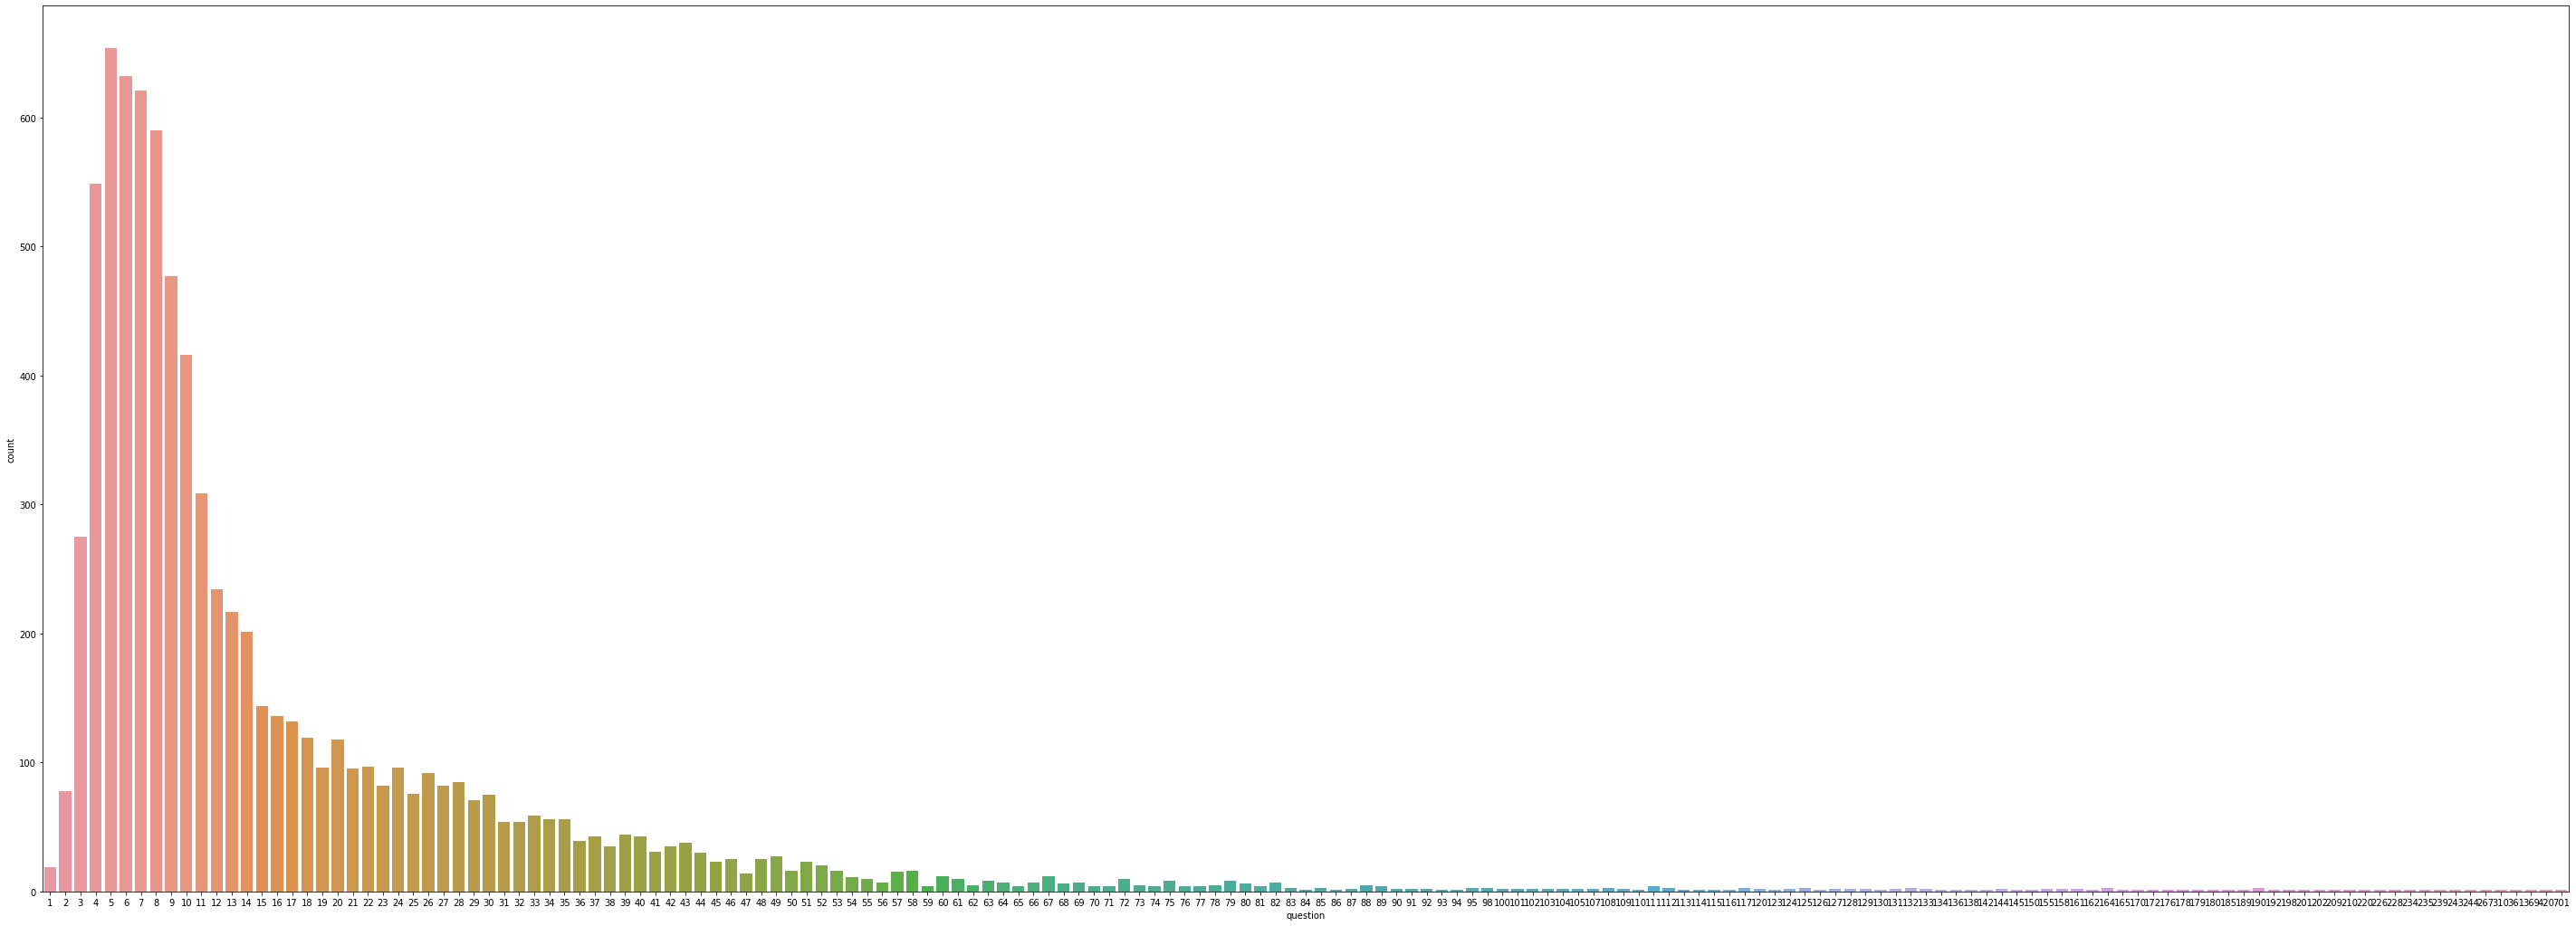

In [5]:
# Quelle est la distribution du nombre de mots par question ?
nb_words = raw_df.question.str.split().apply(len)
a3_dims = (50, 18)
fig, ax = plt.subplots(figsize=a3_dims)
sns.countplot(nb_words, ax = ax)

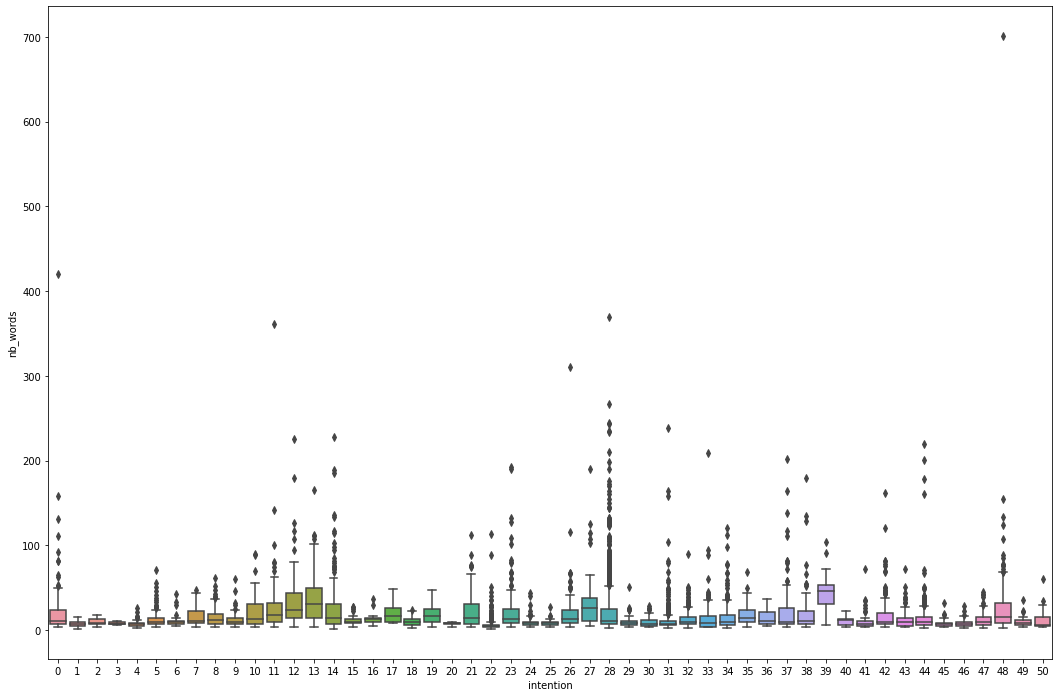

In [6]:
# Plot nb words per target class
a4_dims = (18, 12)
raw_df["nb_words"] = nb_words
raw_df["intention"] = target.intention
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(x="intention", y="nb_words", data=raw_df)

On voit ici, que certaines questions sont extrêmements longues. <br>
Parfois plus de 100 mots sont rédigés pour poser une question. <br>
Cela relève plus du tchat de forum qu'une question directe.

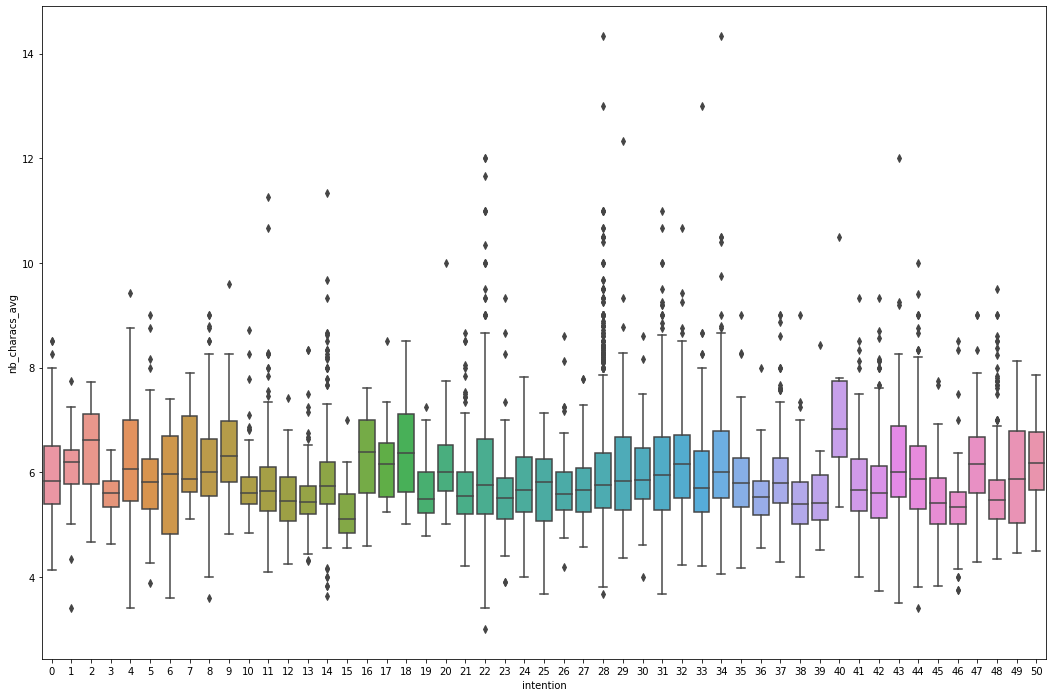

In [7]:
nb_characters = raw_df.question.apply(len)
# Afficher le nombre de caractères moyen par mots en fonction de la variable d'intérêt
raw_df["nb_characs_avg"] = nb_characters/nb_words
fig, ax = plt.subplots(figsize=a4_dims)
ax = sns.boxplot(x="intention", y="nb_characs_avg", data=raw_df)

Certaines classes se distinguent par leur longueur moyenne de mots.
Par exemple, la classe 40 est liée à des mots relativement plus longs alors que l'intention de classe 15 est liée à des questions contenant des mots plus courts. 

### Distribution de la fréquence des maladies les plus communes

C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


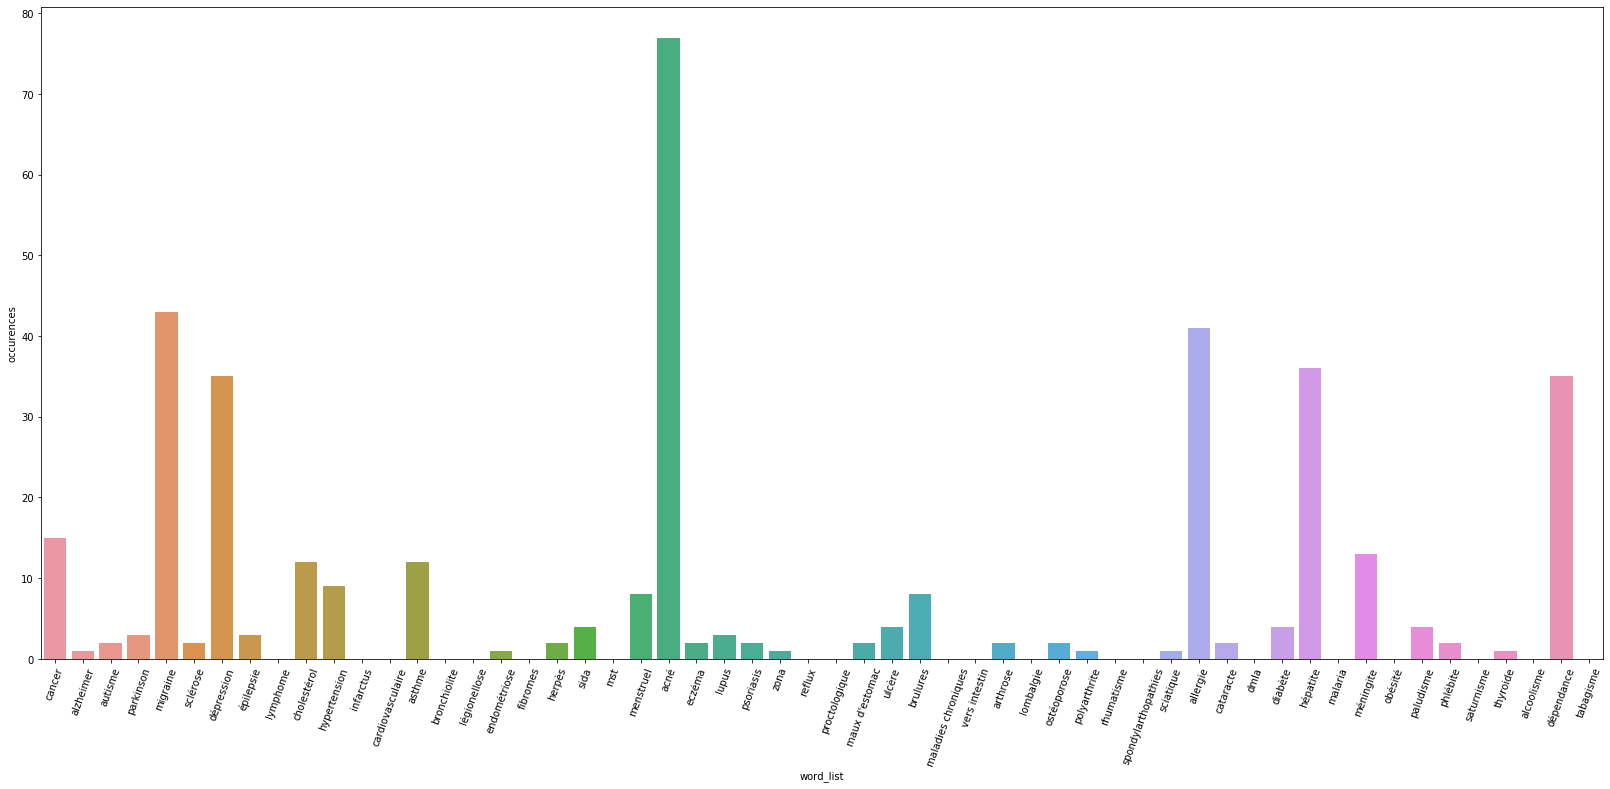

In [8]:
# Le site "doctissimo" liste les maladies les plus fréquentes 
# Nous recensons ici les occurences de ces maladies dans les questions du dataset d'entrainement

# Nous commenceons par retirer les majuscules
#raw_df["question_lower"] = raw_df["question"].apply(lambda x : x.lower())

# Nous listons ces maladies puis nous énumérons leur présence 
frequent_maladies = ["cancer", "alzheimer", "autisme", "parkinson", "migraine", "sclérose", "dépression", "épilepsie", # système nerveux
                    "lymphome", "cholestérol", "hypertension", "infarctus", "cardiovasculaire", "asthme", "bronchiolite", "légionellose", # problèmes respiratoires
                    "endométriose", "fibromes", "herpès", "sida", "mst", "menstruel", # problèmes intimes
                    "acné", "eczéma", "herpès", "lupus", "psoriasis", "zona", # maladies de peau 
                    "reflux", "proctologique", "maux d'estomac","ulcère", "brulures", "maladies chroniques", "vers intestin", # troubles digestifs
                    "arthrose", "lombalgie", "ostéoporose", "polyarthrite", "rhumatisme", "spondylarthopathies", "sciatique" , # os et articulations
                    "allergie", "cataracte", "dmla", "diabète", "hépatite", "malaria", "méningite", "obésité", "paludisme", "phlébite","saturnisme", "thyroide", # grandes maladies
                    "alcoolisme", "dépendance", "tabagisme" # drogues 
                    ]

def look_for_word_occurences(v_words_list):
    nb_occurences = list()
    for freq_mal in v_words_list:
        nb_occurence = raw_df[raw_df["question"].apply(lambda x : x.find(freq_mal))>=0].shape[0]
        nb_occurences.append(nb_occurence)
    frequent_words_occurences_df = pd.DataFrame({"word_list" : v_words_list, "occurences" : nb_occurences})
    maladies_dims = (int(len(v_words_list)/2),12)
    fig, ax = plt.subplots(figsize=maladies_dims)
    ax = sns.barplot( x="word_list", y="occurences", data=frequent_words_occurences_df)
    plt.xticks(rotation=70)
    
look_for_word_occurences(frequent_maladies)

Ici, les noms de maladies les plus fréquentes sont également fréquentes dans notre jeu d'entrainement lorsque leur terminologie est assez générique. <br>
Ainsi <b>migraine, allergie, acné,</b> ou <b>dépendance</b> sont fréquemment rencontrés alors que des termes plus "technique" comme <b>lombalgie</b> sont moins fréquents.

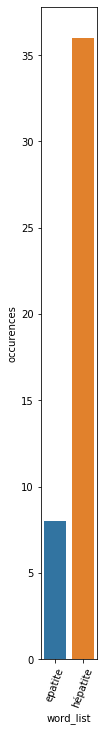

In [9]:
# Quel est l'impact de l'orthographe sur notre recensement ?
look_for_word_occurences(["epatite", "hépatite"])

Nous voyons ici qu'il sera nécessaire de prendre en considération l'approximation orthographique des mots dnas les questions.<br>
Deux approches sont alors possible :
- soit nous entrainons un embedding de mots en espérant croiser suffisament de fois les mêmes fautes d'orthographes pour pouvoir les assimiler à leur mot d'origine
- soit nous encodons les caractères

Cette deuxième option necessitera des capacité de calcul plus grandes mais nous affranchira de l'approximation de l'orthographe des mots.

# Preprocessing
## Marque de la présence d'un médicament dans une question

In [10]:
raw_df = pd.read_csv("input_train.csv")
target = pd.read_csv("output_train.csv")
raw_df["intention"] = target.intention

In [11]:
import pandas as pd
import codecs

# Fichier : CIS_bdpm.txt 
#
# Il contient la liste des médicaments commercialisés ou en arrêt de commercialisation depuis
# moins de trois ans.

doc = codecs.open("./ansm/CIS_bdpm.txt",'rU',encoding="ISO-8859-1") 
CIS_bdpm_df = pd.read_csv(doc, sep='\t', header=None)
CIS_bdpm_df.columns = [ "Code_CIS", # (Code Identifiant de Spécialité)
                        "Denomination_medicament", 
                        "Forme_pharmaceutique", 
                        "Voies_administration", # (avec un séparateur « ; » entre chaque valeur quand il y en a
                                                # plusieurs)
                        "Statut-administratif_AMM", # de l’autorisation de mise sur le marché (AMM)
                        "Type_procedure_autorisation", # de mise sur le marché (AMM)
                        "Etat_commercialisation",
                        "Date_AMM", # (format JJ/MM/AAAA)
                        "StatutBdm", # : valeurs possibles : « Alerte » (icône rouge) ou « Warning disponibilité »
                                     #(icône grise)
                        "Numero_autorisation_euro",
                        "Titulaires", # : S’il y a plusieurs titulaires, les valeurs seront séparées par des « ; »
                        "Surveillance_renforcee"]# (triangle noir) : valeurs « Oui » ou « Non »]
CIS_bdpm_df["Code_CIS"] = CIS_bdpm_df["Code_CIS"].astype(int)
CIS_bdpm_df.head()

,Code_CIS,Denomination_medicament,Forme_pharmaceutique,Voies_administration,Statut-administratif_AMM,Type_procedure_autorisation,Etat_commercialisation,Date_AMM,StatutBdm,Numero_autorisation_euro,Titulaires,Surveillance_renforcee
0,61266250,"A 313 200 000 UI POUR CENT, pommade",pommade,cutanée,Autorisation active,Procédure nationale,Commercialisée,12/03/1998,NaN,NaN,PHARMA DEVELOPPEMENT,Non
1,62869109,"A 313 50 000 U.I., capsule molle",capsule molle,orale,Autorisation active,Procédure nationale,Commercialisée,07/07/1997,NaN,NaN,PHARMA DEVELOPPEMENT,Non
2,62401060,"ABACAVIR MYLAN 300 mg, comprimé pelliculé sécable",comprimé pelliculé sécable,orale,Autorisation active,Procédure décentralisée,Commercialisée,21/02/2018,NaN,NaN,MYLAN SAS,Non
3,63797011,"ABACAVIR SANDOZ 300 mg, comprimé pelliculé sécable",comprimé pelliculé sécable,orale,Autorisation active,Procédure décentralisée,Commercialisée,30/12/2016,NaN,NaN,SANDOZ,Non
4,63431640,"ABACAVIR/LAMIVUDINE BIOGARAN 600 mg/300 mg, comprimé pelliculé",comprimé pelliculé,orale,Autorisation active,Procédure nationale,Commercialisée,14/02/2017,NaN,NaN,BIOGARAN,Non


In [12]:
# On récupère le nom des médicaments
medicament_list = CIS_bdpm_df.apply(lambda x : x["Denomination_medicament"].split()[0].lower().split("/")[0], axis=1)
medicament_list = medicament_list.unique().tolist()
medicament_list.remove("a")
medicament_list.remove("un")
medicament_list.remove("b")
medicament_list

['abacavir',
 'abasaglar',
 'abelcet',
 'abies',
 'abilify',
 'abraxane',
 'abrotanum',
 'absinthium',
 'abstral',
 'abufene',
 'acadione',
 'acalypha',
 'acamprosate',
 'acarbose',
 'acarizax',
 'accofil',
 'accusol',
 'acebutolol',
 'aceclofenac',
 'acetanilidum',
 'acetate',
 'aceticum',
 'acetonum',
 'acetylcysteine',
 'acetylleucine',
 'aciclovir',
 'acide',
 'acidrine,',
 'acidum',
 'aclasta',
 'aclotine',
 'acnetrait',
 'aconitum',
 'acorspray',
 'act-hib',
 'actaea',
 'actapulgite',
 'actheane,',
 'acti',
 'acticarbine',
 'acticarbine,',
 'actifed',
 'actifedsign,',
 'actilyse',
 'actilyse,',
 'actiq',
 'actiskenan',
 'actisoufre',
 'actisoufre,',
 'activelle,',
 'activir',
 'activox',
 'actonel',
 'actonelcombi',
 'actosolv',
 'actrapid',
 'actron,',
 'actynox',
 'acuilix',
 'acuitel',
 'acular',
 'acupan,',
 'adalate',
 'adancor',
 'adapalene',
 'adartrel',
 'adasuve',
 'adcetris',
 'adcirca',
 'adempas',
 'adenoscan',
 'adenosine',
 'adenuric',
 'adenyl',
 'adepal,',
 'adiaz

In [13]:

# On ajoute aux noms de médicaments un pattern sur portera un poids plus important qu'un caractère classique 

def lmgp_medicament_marks(q):

    ponct  = ['.',',','?','!',";","(",")"]
    accent = ['é','è','ê',"ë"]
    
    q2=''
    
    for w in q.split():
        
        pw=''
        
        for c in w:
            if c in accent:       #on supprime ici les éventuels accents
                pw=pw+'e'
            elif c not in ponct:  #on supprime ici les éventuelles ponctuations collées au mot
                pw=pw+c
        
        pw=pw.lower()
        
        if pw in medicament_list: #on recherche si le mot est dans la liste des médicaments
            q2=q2+' #'+w
        else:
            q2=q2+' '+w
            
    return q2


raw_df['question#'] = raw_df['question'].map(lmgp_medicament_marks)

In [14]:
raw_df.head(10)

,ID,question,intention,question#
0,0,"bonjour, je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous",28,"bonjour, je m suis trompé de forum pour ma question alors je la repose ici. je pris pour la première fois hier du #paroxétine et ce matin c'est une catastrophe. picotement dasn tous le corps annonciateur de sueur froide très très massive et de vomissement. j'en suis à deux crises depuis 5 heure du mat. la cela semble passer mes mes mains reste moites et chaude estce normal pour la première fois merci a tous"
1,1,est ce que le motilium me soulagera contre les nausées?,31,est ce que le #motilium me soulagera contre les nausées?
2,2,"mon médecin m'a prescrit adenyl. au 2ème cachet des maux de tête terribles et au 3ème palpitations, sueurs froides, chaleur intense dans la tête, tremblements, fourmillements dans la lèvre supérieure, difficultés à respirer.. dès l'arrêt du médicament tous les symptômes ont disparu. cela est-il déjà arrivé à quelqu'un??",28,"mon médecin m'a prescrit #adenyl. au 2ème cachet des maux de tête terribles et au 3ème palpitations, sueurs froides, chaleur intense dans la tête, tremblements, fourmillements dans la lèvre supérieure, difficultés à respirer.. dès l'arrêt du médicament tous les symptômes ont disparu. cela est-il déjà arrivé à quelqu'un??"
3,3,Est-ce qu'il existe une forme adaptée aux enfant de 5ans du Micropakine ?,44,Est-ce qu'il existe une forme adaptée aux enfant de 5ans du #Micropakine ?
4,4,mon medecin me soigne pour une rhino pharingite et m'a prescrit du amoxicilline comme anti biotique. Est-ce vraiment pour cette indication?,31,mon medecin me soigne pour une #rhino pharingite et m'a prescrit du #amoxicilline comme anti biotique. Est-ce vraiment pour cette indication?
5,5,je viens d'apprendre que je suis enceinte..savez-vous si je peux poursuivre le rubozinc ?,44,je viens d'apprendre que je suis enceinte..savez-vous si je peux poursuivre le #rubozinc ?
6,6,atrax n'est-il pas dangereux au long terme ?,48,atrax n'est-il pas dangereux au long terme ?
7,7,je suis sous mercilon. J'ai des nausées et des saignements ?,28,je suis sous mercilon. J'ai des nausées et des saignements ?
8,8,"L'atenolol, c'est quoi ?",22,"L'atenolol, c'est quoi ?"
9,9,"je prend trinordiol et à la fin de ma première plaquette j'ai eu ma première fois ac mn copain. la pilule est donc bien efficace dès le debut ? j'ai des douleur dans la poitrine, j'ai l'impression qu'ils ont un peu grossi ossi de plus, j'ai mal o bas du ventr,e dois je minkiété ou c simplemen, la periode dadaptation ??",23,"je prend trinordiol et à la fin de ma première plaquette j'ai eu ma première fois ac mn copain. la pilule est donc bien efficace dès le debut ? j'ai des douleur dans la poitrine, j'ai l'impression qu'ils ont un peu grossi ossi de plus, j'ai mal o bas du ventr,e dois je minkiété ou c simplemen, la periode dadaptation ??"


## Définition du dictionnaire de base et gestion des caractères spéciaux

In [15]:
from numpy import argmax

# Définition de l'ensemble des caractères possibles
alphabet = 'abcdefghijklmnopqrstuvwxyz0123456789 .?#' # On ajoutele pattern spécial "#" en fin de notre alphabet

# Mapping des caractères aux entiers et vice-versa
char_to_int = dict((c, i) for i, c in enumerate(alphabet))
int_to_char = dict((i, c) for i, c in enumerate(alphabet))


Quels sont les caracteres qui ne sont pas dans l'alphabet ?

In [16]:
# Définition des caractères spéciaux
d = {}
for q in raw_df['question']:
    for char in q.lower():
        if char not in char_to_int:
            d[ord(char)]=char
print(d)

{44: ',', 233: 'é', 232: 'è', 39: "'", 224: 'à', 234: 'ê', 244: 'ô', 45: '-', 231: 'ç', 40: '(', 47: '/', 41: ')', 8217: '’', 43: '+', 239: 'ï', 58: ':', 61: '=', 62: '>', 33: '!', 174: '®', 37: '%', 160: '\xa0', 8364: '€', 34: '"', 251: 'û', 238: 'î', 249: 'ù', 38: '&', 226: 'â', 59: ';', 252: 'ü', 8203: '\u200b', 8230: '…', 96: '`', 176: '°', 180: '´', 235: 'ë', 187: '»', 8482: '™', 339: 'œ', 42: '*', 171: '«', 177: '±', 91: '[', 93: ']', 95: '_', 64: '@', 168: '¨', 186: 'º', 8226: '•', 125: '}'}


Construction d'un dictionnaire de remplacement des caracteres spéciaux ({code ascii : caractère de remplacement})

In [17]:
rdict = {44: ' ', 233: 'e', 232: 'e', 39: " ", 224: 'a', 234: 'e', 244: 'o', 45: ' ', 231: 'c', 40: ' ', 47: ' ', 41: ' ', 8217: ' ', 43: ' ', 239: 'i', 58: ' ', 61: ' ', 62: ' ', 33: ' ', 174: ' ', 37: ' ', 160: ' ', 8364: ' euros ', 34: ' ', 251: 'u', 238: 'i', 249: 'u', 38: ' et ', 226: 'a', 59: ' ', 252: 'u', 8203: ' ', 8230: ' ', 96: ' ', 176: ' degres ', 180: ' ', 235: 'e', 187: ' ', 8482: ' ', 339: 'oe', 42: ' fois ', 171: ' ', 177: ' plus ou moins ', 91: ' ', 93: ' ', 95: ' ', 64: ' ', 168: ' ', 186: ' ', 8226: ' ', 125: ' '}

Substitution des caractères spéciaux

In [18]:
# On remplace les caractères spéciaux dans les questions
def lmgp_process_words(s):
    
    s = s.lower()
    for t in rdict:
        s=s.replace(chr(t),rdict[t])
        
    s=s.replace("   "," ")
    s=s.replace("  "," ")
    return s

raw_df['q2']=raw_df['question#'].map(lmgp_process_words)


## Choix d'une longueur maximale pour nos questions 

In [19]:
def lmgp_question_len(raw_df):
    raw_df['lq2']=0
    question_len=[]
    
    # On collecte la longueur de chaque question
    for q in raw_df['q2']:
        question_len.append(len(q))
    raw_df['lq2']=question_len
    return raw_df
    
raw_df = lmgp_question_len(raw_df)

In [20]:
pd.reset_option('display.max_colwidth')
raw_df.head()

,ID,question,intention,question#,q2,lq2
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28,"bonjour, je m suis trompé de forum pour ma qu...",bonjour je m suis trompe de forum pour ma que...,410
1,1,est ce que le motilium me soulagera contre les...,31,est ce que le #motilium me soulagera contre l...,est ce que le #motilium me soulagera contre l...,57
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28,mon médecin m'a prescrit #adenyl. au 2ème cac...,mon medecin m a prescrit #adenyl. au 2eme cac...,318
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44,Est-ce qu'il existe une forme adaptée aux enf...,est ce qu il existe une forme adaptee aux enf...,75
4,4,mon medecin me soigne pour une rhino pha...,31,mon medecin me soigne pour une #rhino pharing...,mon medecin me soigne pour une #rhino pharing...,142


### Définion d'une longueur Max
------------
Nous allons travailler sur les questions de longueur <= LMAX telle que nous conservons 98% de nos données

In [21]:
import numpy as np 
q_len = raw_df.apply(lambda x : len(x["question"]), axis=1)
np.percentile(q_len,98)

446.46000000000004

On peut donc arrondir un maximum de caractères à analyser pour conserver un peu plus de 98% des questions à classifier

In [22]:
lmax = 450

In [23]:
# Completion des question plus courtes 
def pad(s,pad=lmax):
    l=len(s)
    to_return = s
    if pad > l:
        n=pad-l
        to_return = s+' '*n
    
    return to_return

def lmgp_resize_question(raw_df, target, lmax):
    
    # On raccourcit les questions trop longues 
    raw_df["q2"] = raw_df.apply(lambda x : x["q2"][:450], axis=1)

    raw_df2 = raw_df.copy()
    target2=target.copy()

    # On va ensuite compléter les chaines avec des blancs par le biais d'un padding à droite
    raw_df2['q2']=raw_df2['q2'].map(pad)
    raw_df2['lq2']=lmax
    return raw_df2, target2


raw_df2, target2 = lmgp_resize_question(raw_df, target, lmax=450)

In [24]:
raw_df2['q2'].head().map(len)

0    450
1    450
2    450
3    450
4    450
Name: q2, dtype: int64

### Quelle est la longueur moyenne du premier mot des questions ?

In [25]:
fw_len = raw_df2.apply(lambda x : len(x["question"].split()[0]), axis=1)
fw_len.mean()

5.220104633781764

Le premier mot d'une question a une longueur comprise entre 5 et 6 caractères, un padding à gauche de 5 caractères permettrait par exemple d'optimiser l'exploitation du premier caractère dans l'entité à laquelle il appartient, soit un mot.

### Encodage des textes
----------------
On va convertir les questions en coding caracteres (indices dans l'alphabet)

In [26]:
def lmgp_integer_encoded(s):
    return [char_to_int[char] for char in s]

In [27]:
def lmgp_encode(raw_df2):
    qlist = [[] for i in range(0,raw_df2.shape[0])]
    i=0
    for c_question in raw_df2['q2']:
        qlist[i]=lmgp_integer_encoded(c_question)
        i+=1
    
    raw_df2['encoded']=qlist
    return raw_df2

raw_df2 = lmgp_encode(raw_df2)

In [28]:
raw_df2.head()

,ID,question,intention,question#,q2,lq2,encoded
0,0,"bonjour, je m suis trompé de forum pour ma qu...",28,"bonjour, je m suis trompé de forum pour ma qu...",bonjour je m suis trompe de forum pour ma que...,450,"[36, 1, 14, 13, 9, 14, 20, 17, 36, 9, 4, 36, 1..."
1,1,est ce que le motilium me soulagera contre les...,31,est ce que le #motilium me soulagera contre l...,est ce que le #motilium me soulagera contre l...,450,"[36, 4, 18, 19, 36, 2, 4, 36, 16, 20, 4, 36, 1..."
2,2,mon médecin m'a prescrit adenyl. au 2ème cache...,28,mon médecin m'a prescrit #adenyl. au 2ème cac...,mon medecin m a prescrit #adenyl. au 2eme cac...,450,"[36, 12, 14, 13, 36, 12, 4, 3, 4, 2, 8, 13, 36..."
3,3,Est-ce qu'il existe une forme adaptée aux enfa...,44,Est-ce qu'il existe une forme adaptée aux enf...,est ce qu il existe une forme adaptee aux enf...,450,"[36, 4, 18, 19, 36, 2, 4, 36, 16, 20, 36, 8, 1..."
4,4,mon medecin me soigne pour une rhino pha...,31,mon medecin me soigne pour une #rhino pharing...,mon medecin me soigne pour une #rhino pharing...,450,"[36, 12, 14, 13, 36, 12, 4, 3, 4, 2, 8, 13, 36..."


## Split Train/test appareillés
------------
Création des jeux de données train/test sur les questions de moins de lmax caractères

Encodage vecteur 0/1 des questions de "lmax" caractères

In [29]:
import numpy as np

# Vectorisation des questions en 1 pour tous les caractères et 0.8 le pattern "#" a été inséré
# celui-ci a été inséré à chqque fois qu'un nom d emédicament a été rencontré dans une question
def lmgp_vectorize_questions(questions, lmax=lmax,lalphabet=len(alphabet)):
    results = np.zeros((len(questions), lmax, lalphabet))
    for i, q in enumerate(questions):
        for j, c in enumerate(q):
            # si on rencontre un "#" : 1 sinon 0.5
            results[i, j, c] = .8 if (c==len(alphabet)) else 1.
    return results


def lmgp_split_vectorize(raw_df2, target2, rate):
    
    train2_df, test2_df, train2_target, test2_target = train_test_split(raw_df2, target2.intention,stratify=target2.intention, test_size=rate)
    train2_df["intention"] = pd.DataFrame({'intention':train2_target})
    test2_df["intention"]  = pd.DataFrame({'intention':test2_target})

    x_train = lmgp_vectorize_questions(train2_df.apply(lambda x : x['encoded'][0:450], axis=1))
    x_test = lmgp_vectorize_questions(test2_df.apply(lambda x : x['encoded'][0:450], axis=1))

    # reshape pour la convolution 2D
    x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
    x_test  = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

    return train2_df, test2_df, train2_target, test2_target, x_train, x_test


## Définition du réseau avec convolution

In [30]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, ZeroPadding2D
from keras.layers import Conv1D,Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam

# Définition de l'architecture de notre réseau de neuronne à convolution
def build_model():
    model = Sequential()

    model.add(ZeroPadding2D(padding=(5,0), input_shape=(lmax, len(alphabet),1))) # Ajout d'un à gauche pour mieux utiliser les premiers caractères
    model.add(Conv2D(1024, (15,len(alphabet)), activation='relu'))

    model.add(MaxPooling2D(pool_size=(3, 1)))
    model.add(MaxPooling2D(pool_size=(148,1)))
    model.add(Flatten())
    model.add(Dense(2048, activation='relu'))
    model.add(Dense(51, activation='softmax'))
    return model

Using TensorFlow backend.


## Validation croisée pour fixer le learning rate

In [31]:
from sklearn.model_selection import StratifiedKFold
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


dict_scores = dict()
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=75)    

# Ajouter une boucle sur Adam(lr pour définir la meilleur valeur de lr
for c_lr in [0.0001, 0.0005, 0.001, 0.005]:
    all_scores = list()
    
    for tr_idx, val_idx in skf.split(raw_df2.encoded, target2.intention):    
    
        # split
        x_train = lmgp_vectorize_questions(raw_df2.iloc[tr_idx,].apply(lambda x : x['encoded'][0:450], axis=1))
        x_test = lmgp_vectorize_questions(raw_df2.iloc[val_idx,].apply(lambda x : x['encoded'][0:450], axis=1))
    
        CV_labels_tr, CV_labels_val = target.iloc[tr_idx]['intention'], target.iloc[val_idx]['intention']
    
        y_train = to_categorical(np.asarray(CV_labels_tr).astype('float32'))
        y_test = to_categorical(np.asarray(CV_labels_val).astype('float32'))
    
        # reshape pour la convolution 2D
        x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
        x_test  = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)

        # Préparation du modèle 
        model = build_model()
        adam = Adam(lr=c_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

        # Exécution
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
        model.compile (optimizer=adam,loss='categorical_crossentropy', metrics=['acc'])
        history = model.fit(x_train, y_train,
                            validation_data=(x_test, y_test),
                            epochs=30,
                            verbose=1,
                            #callbacks = [es],
                            batch_size=32)    
            
        val_acc = model.evaluate(x_test, y_test, verbose=0)
        all_scores.append(val_acc)
    
        dict_scores[c_lr] = np.mean(all_scores)
        

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 5336 samples, validate on 2692 samples
Epoch 1/30
5336/5336 [==============================] - 18s 3ms/step - loss: 3.2529 - acc: 0.2228 - val_loss: 3.0665 - val_acc: 0.2225
Epoch 2/30
5336/5336 [==============================] - 13s 2ms/step - loss: 2.9337 - acc: 0.2665 - val_loss: 2.8223 - val_acc: 0.3135
Epoch 3/30
5336/5336 [==============================] - 13s 2ms/step - loss: 2.6236 - acc: 0.3705 - val_loss: 2.5332 - val_acc: 0.3837
Epoch 4/30
5336/5336 [==============================] - 13s 2ms/step - loss: 2.3283 - acc: 0.4378 - val_loss: 2.3436 - val_acc: 0.4149
Epoch 5/30
5336/5336 [==============================] - 13s 2ms/step - loss: 2.0763 - acc: 0.4946 - val_loss: 2.1824 - val_acc: 0.4428
Epoch 6/30
5336/5336 [==============================] - 13s 2ms/step - loss: 1.8467 - acc: 0.5517 - val_loss: 2.0410 - val_acc: 0.4948
Epoch 7/30
5336/5336 [

5350/5350 [==============================] - 13s 3ms/step - loss: 0.1322 - acc: 0.9884 - val_loss: 1.6517 - val_acc: 0.6348
Epoch 27/30
5350/5350 [==============================] - 13s 3ms/step - loss: 0.1126 - acc: 0.9888 - val_loss: 1.6343 - val_acc: 0.6430
Epoch 28/30
5350/5350 [==============================] - 13s 3ms/step - loss: 0.0957 - acc: 0.9916 - val_loss: 1.7159 - val_acc: 0.6285
Epoch 29/30
5350/5350 [==============================] - 13s 3ms/step - loss: 0.0833 - acc: 0.9940 - val_loss: 1.6909 - val_acc: 0.6251
Epoch 30/30
5350/5350 [==============================] - 13s 3ms/step - loss: 0.0763 - acc: 0.9921 - val_loss: 1.6898 - val_acc: 0.6348
Train on 5370 samples, validate on 2658 samples
Epoch 1/30
5370/5370 [==============================] - 14s 3ms/step - loss: 3.2558 - acc: 0.2231 - val_loss: 3.0417 - val_acc: 0.2250
Epoch 2/30
5370/5370 [==============================] - 13s 3ms/step - loss: 2.9408 - acc: 0.2709 - val_loss: 2.8051 - val_acc: 0.3209
Epoch 3/30
537

5336/5336 [==============================] - 13s 2ms/step - loss: 0.0389 - acc: 0.9919 - val_loss: 2.2544 - val_acc: 0.6204
Epoch 26/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.0484 - acc: 0.9886 - val_loss: 2.1184 - val_acc: 0.6270
Epoch 27/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.0387 - acc: 0.9912 - val_loss: 1.9548 - val_acc: 0.6289
Epoch 28/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.0212 - acc: 0.9936 - val_loss: 2.1038 - val_acc: 0.6415
Epoch 29/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.0266 - acc: 0.9929 - val_loss: 1.9860 - val_acc: 0.6471
Epoch 30/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.0265 - acc: 0.9938 - val_loss: 2.1603 - val_acc: 0.6326
Train on 5350 samples, validate on 2678 samples
Epoch 1/30
5350/5350 [==============================] - 14s 3ms/step - loss: 2.9594 - acc: 0.2862 - val_loss: 2.5345 - val_acc: 0.3775
Epoch 2/30
53

5370/5370 [==============================] - 13s 2ms/step - loss: 0.0363 - acc: 0.9927 - val_loss: 2.0423 - val_acc: 0.6324
Epoch 25/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0285 - acc: 0.9927 - val_loss: 2.1557 - val_acc: 0.6336loss: 0.0287 - acc: 0.992
Epoch 26/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0196 - acc: 0.9948 - val_loss: 2.2454 - val_acc: 0.6219
Epoch 27/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0188 - acc: 0.9957 - val_loss: 2.1537 - val_acc: 0.6321
Epoch 28/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0152 - acc: 0.9961 - val_loss: 2.0397 - val_acc: 0.6448
Epoch 29/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0165 - acc: 0.9957 - val_loss: 2.1309 - val_acc: 0.6373
Epoch 30/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.0144 - acc: 0.9955 - val_loss: 2.0653 - val_acc: 0.6392
Train on 5336 samples, validate on 

5350/5350 [==============================] - 13s 2ms/step - loss: 0.0380 - acc: 0.9907 - val_loss: 2.4191 - val_acc: 0.5900
Epoch 24/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0401 - acc: 0.9892 - val_loss: 2.3759 - val_acc: 0.6117
Epoch 25/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0308 - acc: 0.9925 - val_loss: 2.4297 - val_acc: 0.6258
Epoch 26/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0275 - acc: 0.9925 - val_loss: 2.4843 - val_acc: 0.6042
Epoch 27/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0206 - acc: 0.9942 - val_loss: 2.3697 - val_acc: 0.6191
Epoch 28/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0192 - acc: 0.9944 - val_loss: 2.4545 - val_acc: 0.6184
Epoch 29/30
5350/5350 [==============================] - 13s 2ms/step - loss: 0.0174 - acc: 0.9955 - val_loss: 2.5860 - val_acc: 0.6206
Epoch 30/30
5350/5350 [==============================] - 13s

5336/5336 [==============================] - 13s 2ms/step - loss: 0.1660 - acc: 0.9646 - val_loss: 3.8030 - val_acc: 0.5814
Epoch 23/30
5336/5336 [==============================] - 13s 2ms/step - loss: 0.1460 - acc: 0.9698 - val_loss: 3.9533 - val_acc: 0.5932
Epoch 24/30
5336/5336 [==============================] - 13s 3ms/step - loss: 0.1614 - acc: 0.9672 - val_loss: 4.1327 - val_acc: 0.5736
Epoch 25/30
5336/5336 [==============================] - 13s 3ms/step - loss: 0.1527 - acc: 0.9691 - val_loss: 4.4283 - val_acc: 0.5899
Epoch 26/30
5336/5336 [==============================] - 13s 3ms/step - loss: 0.2353 - acc: 0.9526 - val_loss: 4.6963 - val_acc: 0.5721
Epoch 27/30
5336/5336 [==============================] - 13s 3ms/step - loss: 0.3159 - acc: 0.9438 - val_loss: 4.1373 - val_acc: 0.5769
Epoch 28/30
5336/5336 [==============================] - 13s 3ms/step - loss: 0.2202 - acc: 0.9586 - val_loss: 4.4307 - val_acc: 0.5866
Epoch 29/30
5336/5336 [==============================] - 13s

Epoch 22/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.1199 - acc: 0.9741 - val_loss: 4.0437 - val_acc: 0.5858
Epoch 23/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.1218 - acc: 0.9724 - val_loss: 4.0105 - val_acc: 0.5685
Epoch 24/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.1306 - acc: 0.9709 - val_loss: 4.1715 - val_acc: 0.5858
Epoch 25/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.1709 - acc: 0.9626 - val_loss: 4.5376 - val_acc: 0.5715
Epoch 26/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.2605 - acc: 0.9588 - val_loss: 4.3006 - val_acc: 0.5741
Epoch 27/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.2727 - acc: 0.9505 - val_loss: 4.5306 - val_acc: 0.5594
Epoch 28/30
5370/5370 [==============================] - 13s 2ms/step - loss: 0.2411 - acc: 0.9577 - val_loss: 4.9398 - val_acc: 0.5730
Epoch 29/30
5370/5370 [=========================

In [32]:
dict_scores

{0.0001: 1.1780820662006444,
 0.0005: 1.3711127924590523,
 0.001: 1.5249188110016891,
 0.005: 2.607563444654535}

## Application des hyperparamètres et analyse des résultats

In [33]:
best_lr = 0.0001

In [34]:
train2_df, test2_df, train2_target, test2_target, x_train, x_test = lmgp_split_vectorize(raw_df2, target2, 0.2)

C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Aperçu de l'encoding

In [35]:
train2_df['encoded'].head()

3503    [36, 9, 4, 36, 21, 0, 8, 18, 36, 0, 11, 11, 4,...
6972    [36, 24, 36, 0, 36, 19, 36, 8, 11, 36, 20, 13,...
5599    [36, 39, 2, 7, 0, 12, 15, 8, 23, 36, 15, 8, 11...
313     [36, 12, 14, 13, 36, 12, 4, 3, 4, 2, 8, 13, 36...
1869    [36, 0, 36, 16, 20, 8, 36, 18, 36, 0, 3, 17, 4...
Name: encoded, dtype: object

## Préparation des données pour alimenter le réseau de neuronnes
--------------------------
Conversion des labels

In [36]:
from keras.utils import to_categorical
y_train = to_categorical(np.asarray(train2_df['intention']).astype('float32'))
y_test = to_categorical(np.asarray(test2_df['intention']).astype('float32'))

In [37]:


model = build_model()
adam = Adam(lr=best_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Synthèse de notre architecture et exécution
model.compile (optimizer=adam,loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(x_train, y_train, 
                            validation_data=(x_test, y_test),
                            epochs=30,
                            verbose=1,
                            batch_size=32)    

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_13 (ZeroPaddi (None, 460, 40, 1)        0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 446, 1, 1024)      615424    
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 148, 1, 1024)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_25 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_26 (Dense)             (None, 51)                104499    
Total para

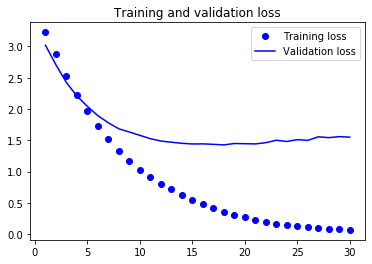

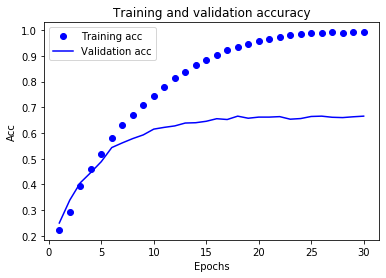

In [38]:
import matplotlib.pyplot as plt

def lmgp_plot_history(history):
    
    # Plot loss
    loss = history.history['loss'] 
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss, 'bo', label='Training loss') 
    plt.plot(epochs, val_loss, 'b', label='Validation loss') 
    plt.title('Training and validation loss') 
    plt.legend()
    plt.show()

    # Plot accuracy 
    acc_values = history.history['acc'] 
    val_acc_values = history.history['val_acc']
    plt.plot(epochs, acc_values, 'bo', label='Training acc') 
    plt.plot(epochs, val_acc_values, 'b', label='Validation acc') 
    plt.title('Training and validation accuracy') 
    plt.xlabel('Epochs') 
    plt.ylabel('Acc') 
    plt.legend()
    plt.show()


lmgp_plot_history(history)

Après 4 epochs, notre réseau apprend du bruit et perd en pertinence.

## Analyse du résultat

Diagonale matrice de confusion

In [39]:
from sklearn.metrics import confusion_matrix

pred=[]
for proba in model.predict(x_test):
    pred.append(np.argmax(proba))
    
cm = confusion_matrix(test2_df['intention'], pred)
nbl = cm.shape[0]
for i in range(nbl):
    print(i,":",cm[i,i]," / ",sum(cm[i,:]))


0 : 20  /  41
1 : 1  /  5
2 : 3  /  4
3 : 0  /  2
4 : 4  /  15
5 : 9  /  20
6 : 2  /  5
7 : 1  /  4
8 : 19  /  27
9 : 8  /  11
10 : 7  /  14
11 : 23  /  39
12 : 11  /  18
13 : 19  /  24
14 : 28  /  63
15 : 4  /  5
16 : 0  /  3
17 : 0  /  3
18 : 1  /  5
19 : 1  /  4
20 : 2  /  4
21 : 19  /  36
22 : 80  /  92
23 : 30  /  42
24 : 4  /  13
25 : 0  /  6
26 : 1  /  14
27 : 7  /  21
28 : 299  /  359
29 : 9  /  15
30 : 4  /  10
31 : 72  /  113
32 : 45  /  64
33 : 19  /  29
34 : 55  /  77
35 : 3  /  10
36 : 1  /  5
37 : 7  /  25
38 : 14  /  24
39 : 0  /  8
40 : 0  /  1
41 : 5  /  9
42 : 43  /  63
43 : 2  /  18
44 : 90  /  112
45 : 8  /  10
46 : 6  /  9
47 : 13  /  16
48 : 64  /  78
49 : 2  /  4
50 : 4  /  7


On constate ici qu'il y a une corrélation forte entre le nombre d'erreur et le nombre d'occurrences de ces classes target

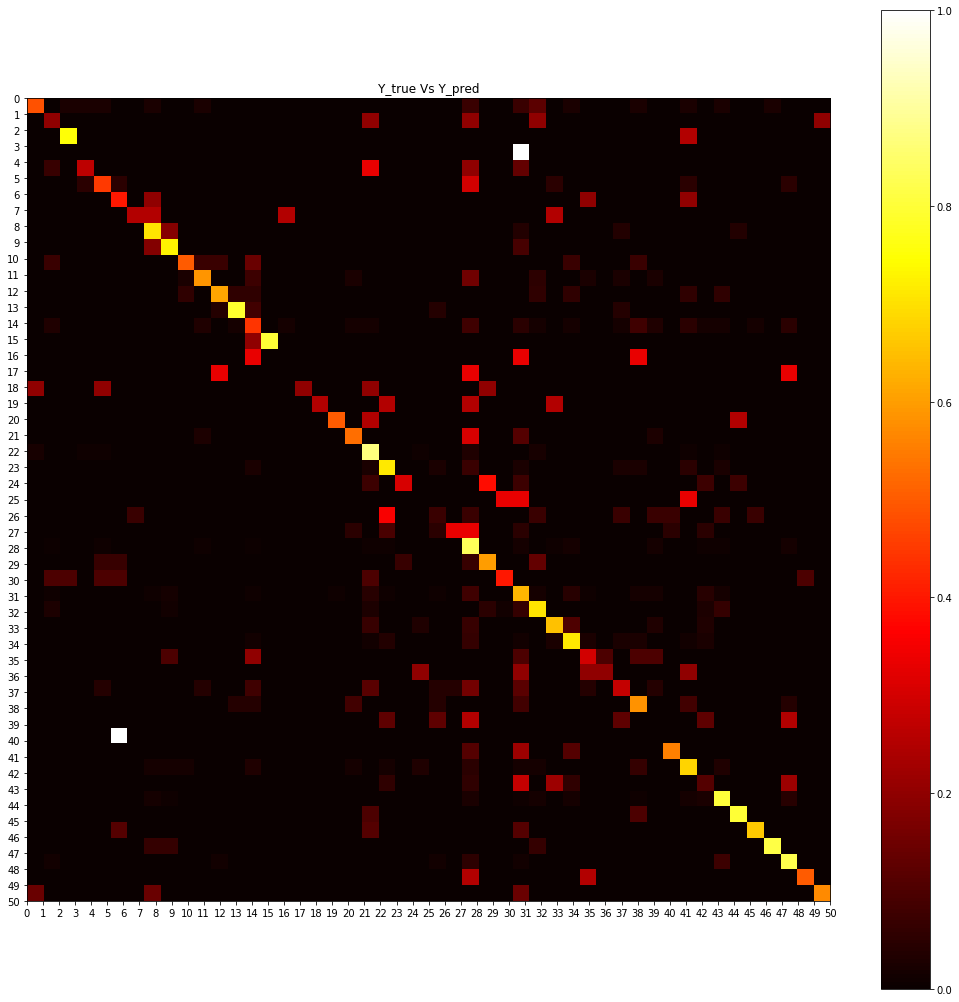

In [40]:
import seaborn as sns

# Transforme un encodage des classes target en valorisation des classes
def lmgp_reverse_dummies(y):
    # Identification de la classe prédite pour chaque ligne du dataset de validation avec la probabilité max
    max_per_line = np.max(y, axis=1)

    # On parcours les prédictions de chaque ligne du dataset de validation
    # et on récupère l'indice de la probabilité de prédiction maximale
    return [ list(y[i]).index(list(max_per_line)[i]) for i in range(0,len(max_per_line))]


def lmgp_analyze_pred(y_pred, y_val, v_class):
    # On récupère les valeurs des classes prédites
    pred_classes_val = lmgp_reverse_dummies(y_pred)
    
    # On transfome de la même façon les classes réelles
    y_classes_val = lmgp_reverse_dummies(y_val)
    
    # On formatte ces résultats dans un dataframe
    y_analyse_df = pd.DataFrame({"y_classes_val":y_classes_val,"pred_classes_val":pred_classes_val})
    pred_for_classe = y_analyse_df.loc[y_analyse_df["y_classes_val"]==v_class, "pred_classes_val"]

    # Distribution par ratio des predictions
    intention_rate = pred_for_classe.value_counts(normalize=True).mul(100).round(2).sort_index(ascending=True)
    intention_rate_df = pd.DataFrame({"intention":intention_rate.index, "intention_rate":intention_rate.values})
        
    fig, ax = plt.subplots(figsize=(12, 8))
    sns.barplot(x="intention", y="intention_rate", data=intention_rate_df, ax=ax)
    plt.title("Prédictions de la classe : "+str(v_class))    

    
def lmgp_display_errors(y_pred, y_val):
    # On récupère les valeurs des classes prédites
    pred_classes_val = lmgp_reverse_dummies(y_pred)
    
    # On transfome de la même façon les classes réelles
    y_classes_val = lmgp_reverse_dummies(y_val)
    
    # On formatte ces résultats dans un dataframe
    y_analyse_df = pd.DataFrame({"y_classes_val":y_classes_val,"pred_classes_val":pred_classes_val})

    #d = pd.DataFrame(0, index=np.arange(len(data)), columns=feature_list)
    
    for v_class in range(1,51):
        pred_for_classe = y_analyse_df.loc[y_analyse_df["y_classes_val"]==v_class, "pred_classes_val"]

        # Distribution par ratio des predictions
        intention_rate = pred_for_classe.value_counts(normalize=True).mul(100).round(2).sort_index(ascending=True)
        intention_rate_df = pd.DataFrame({"intention":intention_rate.index, "intention_rate":intention_rate.values})
        
        
    return y_analyse_df
    

y_pred = model.predict(x_test, verbose=0)

# Construction de la matrice prédictions - valeurs réelles 
df = lmgp_display_errors(y_pred, y_test)
df_mat = df.groupby([ 'y_classes_val', 'pred_classes_val']).size().unstack(fill_value=0).values

# Normalisation des prédictions
row_sums = df_mat.sum(axis=1)
df_mat = df_mat / row_sums[:, np.newaxis]

# Affichage de la matrice des prédictions
fig, ax = plt.subplots(figsize=(18,18))
plt.imshow(df_mat, cmap='hot', interpolation="nearest", extent=[0,50,50,0])
ax.set_title("Y_true Vs Y_pred")

ax = plt.gca()
xticks = range(0,51)
yticks = range(0,51)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.colorbar()
plt.show()
   

La matrice de confusion permet de constater que certaines classes sont confondues par notre modèle à convolution.<br>
Par exemple, la classe 39 n'est jamais reconnue et toujours confondue avec la classe 26

## Définition du réseau récursif de type LSTM au niveau des mots

In [41]:
import pandas as pd
from sklearn.model_selection import train_test_split
import csv
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Embedding, LSTM
from keras.layers import Conv1D,Conv2D, MaxPooling1D, AveragePooling2D, SpatialDropout1D
from keras.optimizers import SGD, Adam
from keras.callbacks import EarlyStopping

# Lectures des fichiers
lstm_raw_df = pd.read_csv("input_train.csv")
lstm_target = pd.read_csv("output_train.csv")



rdict = {44: ' ', 233: 'e', 232: 'e', 39: " ", 224: 'a', 234: 'e', 244: 'o', 45: ' ', 231: 'c', 40: ' ', 47: ' ', 41: ' ', 8217: ' ', 43: ' ', 239: 'i', 58: ' ', 61: ' ', 62: ' ', 33: ' ', 174: ' ', 37: ' ', 160: ' ', 8364: ' euros ', 34: ' ', 251: 'u', 238: 'i', 249: 'u', 38: ' et ', 226: 'a', 59: ' ', 252: 'u', 8203: ' ', 8230: ' ', 96: ' ', 176: ' degres ', 180: ' ', 235: 'e', 187: ' ', 8482: ' ', 339: 'oe', 42: ' fois ', 171: ' ', 177: ' plus ou moins ', 91: ' ', 93: ' ', 95: ' ', 64: ' ', 168: ' ', 186: ' ', 8226: ' ', 125: ' '}

# Remplacement des caracteres speciaux
def process_words(s):
    
    s = s.lower()

    for t in rdict:
        s=s.replace(chr(t),rdict[t])
        
    s=s.replace("   "," ")
    s=s.replace("  "," ")
    return s

lstm_raw_df['q2']=lstm_raw_df['question'].map(process_words)


chardict = [("é","e"),("è","e"),("à","a"),("ê","e"),("'"," "),("?",""),("û","u"),
            ("ù","u"),("?"," "),("!"," "),("mg"," mg"),(","," "),("."," "),
            ("("," "),(")"," "),("’"," "),("-"," "),("\""," "),(";"," "),("•"," ")]


#remplacement du nom des medicaments par "medoc"
basem = csv.reader(open("base_medicaments_2017.csv"))

entete = next(basem)
raw_basem = list()
for row in basem:
    raw_basem.append(row)
    
medic     = {}
ATCdic    = {}
ATC2dic   = {}
EphMRAdic = {}

index = 0

for row in raw_basem:
    
    s             = row[1].split()
    keys          = s[0].split("/")
    EphMRA        = row[3]
    EphMRAclass   = row[4]
    ATC           = row[5]
    ATCclass      = row[6]
    ATC2          = row[7]
    ATC2class     = row[8]
    teuro         = int(row[9].replace(",","").split()[0])
    tremb         = int(row[11].replace(",","").split()[0])
    nbb           = int(row[10].replace(",",""))
       
    ATCdic[ATC]       = ATCclass
    ATC2dic[ATC2]     = ATC2class
    EphMRAdic[EphMRA] = EphMRAclass   
        
    for key in keys:

        if key not in medic: 
            medic[key.lower()]={"Index" : index, "EphMRA" : EphMRA,"ATC" : ATC,"ATC2" : ATC2, "TEURO" : teuro,"TREMB" : tremb, "NBB" : nbb}   
            index += 1
        else:
            medic[key]["NBB"]   = medic[key]["NBB"]   + nbb #on fait la somme des boites qui portent le meme nom
            medic[key]["TEURO"] = medic[key]["TEURO"] + teuro
            medic[key]["TREMB"] = medic[key]["TREMB"] + tremb


nq2=[]
s=0
for q in lstm_raw_df['q2']:
    q2 = q
    for w in q.split():
        last=w[-1]
        if last == '.' or last == '?':
            w=w[:-1]
            
        if w in medic:
            q2=q2.replace(w,'medoc')
    nq2.append(q2)
lstm_raw_df['q2'] = nq2


stopword3 = ["et","si","on","par","a","les","le","du","la","a","si","de",
          "un","une","il","ils","elle","elles","l","d","y","t","est","sont","ce","qu","je","j","ai",
          "en","pour","mais","me","m","pas","au","des","suis",":","ne","mon","mes",
          "avec","ma","se","c","?","??","n","l","eu","vous","s","que",
          "qui","ou","est-ce","dans","sa","ça","!","?",
          "ge","es","soit","vos","nos","moi","jai","ca","ds","va","bonjour","merci","ont"]


nq2=[]
for q in lstm_raw_df['q2']:
    s=''
    for w in q.split():
        if w not in stopword3:
            s = s + ' ' + w
    s = s[1:]
    nq2.append(s)

lstm_raw_df['q2'] = nq2



MAX_NB_WORDS = 10000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 200

tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(lstm_raw_df['q2'].values)
word_index = tokenizer.word_index

X = tokenizer.texts_to_sequences(lstm_raw_df['q2'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)

lstm_target2=lstm_target.copy()
X_train2, X_test2, Y_train, Y_test = train_test_split(X,lstm_target2.intention,stratify=lstm_target2.intention, test_size = 0.21, random_state = 42)

Y_train2 = pd.get_dummies(Y_train).values
Y_test2  = pd.get_dummies(Y_test).values


# Architecture du réseau LSTM
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(51, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


model.summary()

epochs = 25
batch_size = 64

history = model.fit(X_train2, Y_train2, epochs=epochs, batch_size=batch_size,validation_data=(X_test2,Y_test2),validation_split=0)





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 250, 200)          2000000   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 250, 200)          0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               120400    
_________________________________________________________________
dense_27 (Dense)             (None, 51)                5151      
Total params: 2,125,551
Trainable params: 2,125,551
Non-trainable params: 0
_________________________________________________________________
Train on 6342 samples, validate on 1686 samples
Epoch 1/25
6342/6342 [==============================] - 50s 8ms/step - loss: 3.2452 - acc: 0.2099 - v

Nous obtenons ici une précision maximale à  62.22% avant d'apprendre du bruit.<br>
Ce résultat est moins bon que les 66.56% obtenus par encodage des caractères et réseau de convolution.<br>
En revanche, le réseau de neuronne récursif converge plus vite que le réseau de neuronnes à convolution.

## DATA Augmentation

### Entrainement d'un modèle Word2Vec afin de faire des remplacements par synonyme

-------------

####  Entrainement sur le dataset des questions

In [42]:
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import re
import unicodedata

# Fonction de nettoyage de texte
# option : suppression des "stopwords"
#          restriction au radical
def text_to_wordlist(text, remove_stopwords=False, stem_words=False):
    
    # Convert words to lower case and split them
    text = text.lower().split()

    # Remove stop words if option set
    if remove_stopwords:
        stops = set(stopwords.words("french"))
        text = [w for w in text if not w in stops]
    
    text = " ".join(text)

    # Clean the text
    text = re.sub(r"[^A-Za-z0-9^,.\/éèêùûà'+-=]", " ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"estce", "est ce", text)
    text = re.sub(r"\.", ".", text)     
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"é", "e", text)
    text = re.sub(r"è", "e", text)
    text = re.sub(r"ê", "e", text)
    text = re.sub(r"ù", "u", text)
    text = re.sub(r"û", "u", text)
    text = re.sub(r"à", "a", text)

    text = unicodedata.normalize('NFKD', text)
    
    # Optionally, shorten words to their stems
    if stem_words:
        text = text.split()
        stemmer = SnowballStemmer('french')
        stemmed_words = [stemmer.stem(word) for word in text]
        text = " ".join(stemmed_words)
    
    # Return a list of words
    return(text)




In [43]:
# On formate les questions 
raw_df["question_cleaned"] = raw_df["question"].apply(lambda x : text_to_wordlist(x, remove_stopwords=True, stem_words= False))

In [44]:
# Construction du dictionnaire word2Vec sur les questions fournies dans le challenge
from gensim.models import word2vec
import numpy as np

########################################
## Construction du vocab 
########################################
EMBEDDING_DIM = 128
m_epochs = 20
MAX_NB_WORDS = 20000

wv_model = word2vec.Word2Vec(raw_df['question_cleaned'].apply(lambda x : x.split()), 
                          sg=1, # skip gram : utilisé pour les mots rares
                          #negative=5, # negative sampling : pour ajouter du bruit  
                          size=EMBEDDING_DIM, # Vector dimension 
                          window=20, # fenêtre d'encapsulage des mots
                          min_count=1, # min occurences nb
                          workers=1, 
                          iter=m_epochs # epoch
                         )
print('Found %s word vectors of word2vec' % len(wv_model.wv.vocab))



C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


Found 10890 word vectors of word2vec


In [45]:
# Sauvegarde du model word2vec
wv_model.save("posos_word2vec.model")


C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Chargement du modèle word2vec

In [46]:
from gensim.models import word2vec
import numpy as np

EMBEDDING_DIM = 128
m_epochs = 100
MAX_NB_WORDS = 20000

# Chargement du model word2vec
wv_model = word2vec.Word2Vec.load("posos_word2vec.model")


C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\smart_open\smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


### Augmentation des données par ajout/suppression et remplacement

#### Fonction de  suppression d'un caractère

In [47]:
import random

# On supprime un caractère au hasard
def lmgp_remove_char(a_string):
    index = random.randint(0, len(a_string)-1)
    return a_string[:index] + a_string[index+1:]

#### Fonction d'ajout de bruits par erreur QWERTY

In [48]:

# Augmentation des données par substitution des erreurs référencées 
# dans le dictionnaire de liste de valeurs de substitution passé en paramètre
def lmgp_DicList_aug(phrase, dictList):
    
    words_list = phrase.split()
    c_replaced=0
    new_phrase = phrase
    
    # Si il est possible de faire au moins une substitution
    if any(x in phrase for x in list(dictList.keys())):
        
        # Tant que la substitution n'a pas été faite une fois
        while c_replaced==0:
            # On tire un mot à modifier 
            word_to_modify = words_list[random.randint(0, len(words_list)-1)]
            for key, values in dictList.items():
                # Si la substitution peut avoir lieu, arrêt de la fonction
                if key in word_to_modify:
                    value = values[random.randint(0, len(values)-1)]
                    new_word = word_to_modify.replace(key, value)
                    new_phrase = phrase.replace(word_to_modify,new_word)
                    c_replaced = 1

    return new_phrase

In [49]:
# Dictionnaire des listes d'erreurs de frappe qwerty liées au clavier QWERTY
from collections import defaultdict

# Fonction créant le dictionnaire de listes d'erreurs 
def lmgp_create_dictlist(key_values, dict_qwerty):
        
    for key, cchar in key_values:
        dict_qwerty[key].append(cchar)
    return dict_qwerty

dict_QWERTY = defaultdict(list)
elist = [('e','w'),('e','r'),('e','s'),('e','d'),('e','f')]
dict_QWERTY = lmgp_create_dictlist(elist, dict_QWERTY)

elist = [('h','t'),('h','y'),('h','u'),('h','g'),('h','j')]
dict_QWERTY = lmgp_create_dictlist(elist, dict_QWERTY)

elist = [('k','u'),('k','i'),('k','o'),('k','j'),('k','')]
dict_QWERTY = lmgp_create_dictlist(elist, dict_QWERTY)


#### Fonction d'ajout de bruits par erreur OCR

In [50]:
# Dictionnaire des erreurs de conversion des interpréteurs d'images
dict_OCR={'o' : list('0'),
'l' : list('1'),
'b' : list('6')}
   

#lmgp_OCR_aug("Le pere noel est trop gros")
#lmgp_OCR_aug("meme pas vrai!")
lmgp_DicList_aug("il est maigre au liban!", dict_OCR)

'il est maigre au li6an!'

#### Fonction de substitution par similarité vocabulaire word2vec contextuel

In [51]:
# Ajout de bruit par remplacement de synonym
def lmgp_synonym_aug(question, replacement_rate):
    
    question_splited = question.split()
    question_len = len(question_splited)
    nb_words_to_change = int(question_len * replacement_rate)
    
    # On modifie les mots par un synonyme jusqu'à avoir changé 20% de la phrase
    nb_words_changed = 0
    for word_to_change in question_splited:
        if (word_to_change in wv_model.wv.vocab) & (word_to_change not in stopwords.words("french")):
            question = question.replace( word_to_change, wv_model.wv.similar_by_word(word_to_change)[random.randint(1,2)][0])
            nb_words_changed = nb_words_changed + 1
            
            # Si l'on a changé suffisament de mots on retourne la question transformée
            if nb_words_changed == nb_words_to_change:
                # On retire un caractère au hasard avant de sortir
                question = lmgp_remove_char(question)
                
                return question
        
    return question

# On remplace notre mot par l'un de ses 2 synonymes
lmgp_synonym_aug("la betadine est elle vraiment  bien pour les enfants qui partent en vacances avec leur grands parents tout l ete", 0.2)

'la antidiabetiques et elle qqu  neuropsychiatre pour harpagopytum enfants qui partent en vacances avec leur grands parents tout l ete'

### Application des différentes méthodes d'augmentations de données 

In [52]:
# Flow de modification des phrases permettant d'augmenter nos données 
def lmgp_AUG_flow(phrase):
    phrase = lmgp_remove_char(phrase)
    phrase = lmgp_DicList_aug(phrase, dict_QWERTY)
    phrase = lmgp_DicList_aug(phrase, dict_OCR)
    phrase = lmgp_remove_char(phrase)
    phrase = lmgp_DicList_aug(phrase, dict_QWERTY)
    phrase = lmgp_DicList_aug(phrase, dict_OCR)
    phrase = lmgp_synonym_aug(phrase, 0.2)
    return phrase

    

# Preprocessing des données + data augmentation

In [53]:
raw_df = pd.read_csv("input_train.csv")
target = pd.read_csv("output_train.csv")
raw_df["intention"] = target.intention

In [54]:
# Listing des classes sous représentées, moins de 1%
threshol_rate = 1

def lmgp_data_augmentation(raw_df, target, threshol_rate = 1):
    
    intention_rate = target["intention"].value_counts(normalize=True).mul(100).round(2).sort_index(ascending=True)   
    weak_classes = list(intention_rate[intention_rate<threshol_rate].index)
    weak_classes_df = pd.DataFrame({"weak_classes" : weak_classes})

    # calcul du nombre de d'exécution de la procédure de création de données 
    # pour cela on souhaite que chaque classe ayant moins de "threshold_rate" points 
    # soit augmentée jusqu'à avoir l'équivalent de 20% des points initiaux
    weak_classes_df["nb_ops"] = (20/intention_rate).apply(lambda x : int(x)+1)

    # Initialisation de la nouvelles liste des données
    new_question_list = list(raw_df["question"].copy())
    new_target_list = list(target["intention"].copy())

    # Augmentation des données
    wclasses = list(weak_classes_df["weak_classes"])
    nb_ops_s = list( weak_classes_df["nb_ops"])

    
    for i, wclass in enumerate(wclasses):
        nb_ops = nb_ops_s[i]
        questions = raw_df.loc[target.intention==wclass, "question"]
        for question in questions :
            for i in range(1, (nb_ops+1)):
                #print(question)
                #question = lmgp_AUG_flow(question)
                new_question_list.append(lmgp_AUG_flow(question))
                new_target_list.append(wclass)

    raw_df = pd.DataFrame({"question":new_question_list,"intention":new_target_list})
    
    target = pd.DataFrame({"intention":new_target_list})

    return raw_df, target



In [58]:

# Split des données
rate=0.2
train2_df, test2_df, train2_target, test2_target = train_test_split(raw_df, target.intention,stratify=target.intention, test_size=rate)
train2_df["intention"] = train2_target.values
test2_df["intention"]  = test2_target.values
train2_target = pd.DataFrame({'intention':train2_target.values})
test2_target = pd.DataFrame({'intention':test2_target.values})

train2_df = train2_df.reset_index(drop=True)
test2_df = test2_df.reset_index(drop=True)
train2_target = train2_target.reset_index(drop=True)
test2_target = test2_target.reset_index(drop=True)


# Ici on augmente les données uniquement sur le train pour éviter toute corrélation entre les 2 dataset train et test
train2_df, train2_target = lmgp_data_augmentation(train2_df, train2_target, threshol_rate = 20)


# PrepProcess Train & Test
# On pose des ancres pour chaque médicament

#train2_df = lmgp_medicament_marks(train2_df)
train2_df['question#'] = train2_df['question'].map(lmgp_medicament_marks)
train2_df['q2']=train2_df['question#'].map(lmgp_process_words)
train2_df = lmgp_question_len(train2_df)
train2_df["q2"] = train2_df.apply(lambda x : x["q2"][:450], axis=1)

test2_df['question#'] = test2_df['question'].map(lmgp_medicament_marks)
test2_df['q2']=test2_df['question#'].map(lmgp_process_words)
test2_df = lmgp_question_len(test2_df)
test2_df["q2"] = test2_df.apply(lambda x : x["q2"][:450], axis=1)

# On encode et on format les données
train2_df, train2_target = lmgp_resize_question(train2_df, train2_target, lmax=450)
train2_df = lmgp_encode(train2_df)
train2_df["intention"] = train2_target["intention"]
train2_df = train2_df.reset_index(drop=True)

test2_df, test2_target = lmgp_resize_question(test2_df, test2_target, lmax=450)
test2_df = lmgp_encode(test2_df)
test2_df["intention"] = test2_target["intention"]
test2_df = test2_df.reset_index(drop=True)


# On vectorize les questions
x_train = lmgp_vectorize_questions(train2_df.apply(lambda x : x['encoded'][0:450], axis=1))
x_test = lmgp_vectorize_questions(test2_df.apply(lambda x : x['encoded'][0:450], axis=1))

# Reshape pour la convolution 2D
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],x_train.shape[2],1)
x_test  = x_test.reshape(x_test.shape[0],x_test.shape[1],x_test.shape[2],1)
    
from keras.utils import to_categorical
y_train = to_categorical(np.asarray(train2_df['intention']).astype('float32'))
y_test = to_categorical(np.asarray(test2_df['intention']).astype('float32'))
    
model_aug = build_model()
adam = Adam(lr=best_lr, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

# Synthèse de notre architecture et exécution
model_aug.compile (optimizer=adam,loss='categorical_crossentropy', metrics=['acc'])
model_aug.summary()

history_aug = model_aug.fit(x_train, y_train, 
                            validation_data=(x_test, y_test),
                            #callbacks = [es],
                            epochs=20,
                            verbose=1,
                            batch_size=64) 




C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
C:\Users\query\Anaconda3_New\envs\tf_gpu\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_15 (ZeroPaddi (None, 460, 40, 1)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 446, 1, 1024)      615424    
_________________________________________________________________
max_pooling2d_29 (MaxPooling (None, 148, 1, 1024)      0         
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 1, 1, 1024)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_30 (Dense)             (None, 2048)              2099200   
_________________________________________________________________
dense_31 (Dense)             (None, 51)                104499    
Total para

Le résultat ici est légèremetn moins bon que le résultat obtenu précédemment sans Augmentation de donnée. Le remplacements par "synonyme" réalisés lors de cette augmentation sont probablment trop éloigné de réel synonymes pour conserver le sens inital de la question et génère donc plus un bruit trop important. 

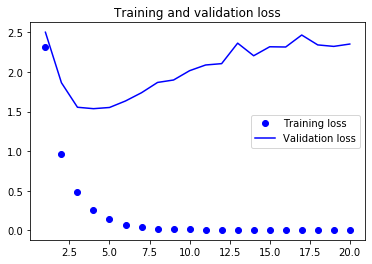

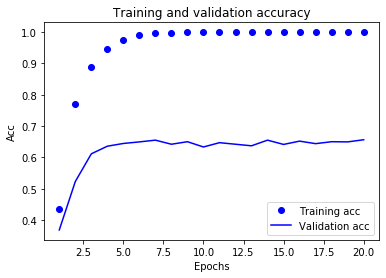

In [59]:
lmgp_plot_history(history_aug)

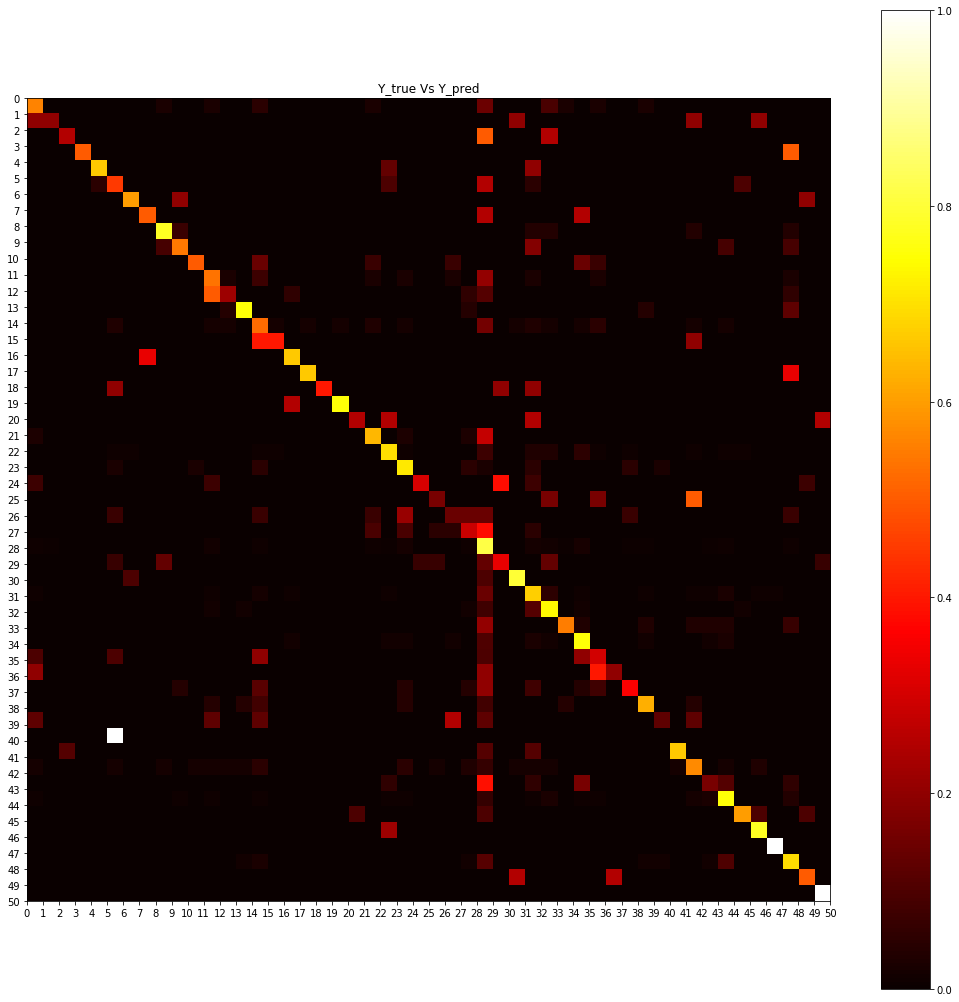

In [60]:
y_pred = model_aug.predict(x_test, verbose=0)

# Construction de la matrice prédictions - valeurs réelles 
df = lmgp_display_errors(y_pred, y_test)
df_mat = df.groupby([ 'y_classes_val', 'pred_classes_val']).size().unstack(fill_value=0).values

# Normalisation des prédictions
row_sums = df_mat.sum(axis=1)
df_mat = df_mat / row_sums[:, np.newaxis]

# Affichage de la matrice des prédictions
fig, ax = plt.subplots(figsize=(18,18))
plt.imshow(df_mat, cmap='hot', interpolation="nearest", extent=[0,50,50,0])
ax.set_title("Y_true Vs Y_pred")

ax = plt.gca()
xticks = range(0,51)
yticks = range(0,51)
ax.set_xticks(xticks)
ax.set_yticks(yticks)

plt.colorbar()
plt.show()

# Conclusion

<b>Pour aller plus loin</b>, nous envisagerions dans un premier temps de faire une moyenne des modèles LSTM et CNN puis d'étudier d'autres architectures de réseaux de convolution et de réseaux récursifs.
<br>
<br>Par exemple, le <b>VGGNet Smaller pour les convolutions et une architecture de type GRU</b>.
<br>Nous rechercherions également un réseau de neuronnes déja entrainé sur de la classification de textes et le ré-exploiterions par <b>transfer learning</b>. 
<br>L'étape d'augmentation des données n'a pas apportée l'amélioration attendue, cela est très probablement lié à la faible qualité des remplacements par similarité du word embedding produit par un word2vec sur un pannel trop faible de textes. Cela devrait pouvoir être également amélioré via la <b>diversification des méthodes de bruitage et par une substitution</b>. 
<br>Nous aimerions également tester une <b>classification hiérarchique</b> afin de gérer le problème de déséquilibre des classes. Cela se ferait par itération en regroupant à chaque étape deux ensemble de tailles équivalentes, en ligne, de classes target.<br>
<br>Enfin, un <b>pré-processing plus poussé des questions de train et test</b>, par exemple par la construction d'un dictionnaire de correction des mots type sms : pkoi --> pourquoi, apportera certainement une amélioration très sensible des résultats mais représentera un temps de traitement très important.<br><br>
Nous envisageons de reprendre le projet en septembre dans le cadre du challenge de l'ENS et d'approfondir dans le même temps nos connaissances des réseaux de neuronnes d'une part et le champ du Natural Language Processing dans le même temps.